# Topic Modeling for Humans of New York Posts
#### Code tweaked from template from Patrick Harrison
#### A similar process was performed for the the Humans of New York comments. There are ~6.5k posts in contrast to the over 2 million comments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
import numpy as np
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim
import warnings
import cPickle as pickle
import json
import itertools as it
import os
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
import codecs
import spacy
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


C:\Anaconda2\lib\site-packages\ipykernel\pylab\config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
C:\Anaconda2\lib\site-packages\ipykernel\pylab\config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
C:\Anaconda2\lib\site-packages\ipykernel\pylab\config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
C:\Anaconda2\lib\site-packages\ipykernel\pylab\config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='v

In [6]:
#Pull text for Humans of New York posts
df = pd.read_csv('humansofnewyork_facebook_statuses_complete.csv')

In [7]:
#Discover posts with high "anger" to "love" ratio
df['AngryToLove'] = 100*(df.num_angrys*1.0)/(df.num_loves*1.0)
df_stats = df.iloc[:278]

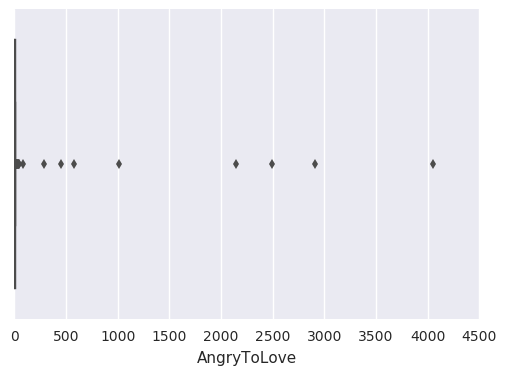

In [4]:
sns.boxplot(df_stats['AngryToLove'])

In [5]:
df_stats['AngryToLove'].describe()

count     278.000000
mean       52.585564
std       363.450926
min         0.000000
25%         0.027691
50%         0.106939
75%         0.889502
max      4052.134146
Name: AngryToLove, dtype: float64

In [6]:
#Upon further analysis, most "angry" posts are due to a unified anger towards a subject and not due to a divide in the audience.
#An example is a post about a corrupt District Attourney office
df_stats.sort('AngryToLove')

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,AngryToLove
128,102099916530784_1271236926283738,HONY Stories is 50% off at Amazon for the next...,Timeline Photos,photo,https://www.facebook.com/humansofnewyork/photo...,6/6/2016 17:15,17172,356,424,15023,911,18,1219,1,0,0.000000
188,102099916530784_1249271921813572,"""A big part of a nurse's job is translation. ...",Timeline Photos,photo,https://www.facebook.com/humansofnewyork/photo...,5/6/2016 11:52,170993,2242,6952,151892,16804,57,2006,116,0,0.000000
150,102099916530784_1257362977671133,"(6/6) ""If I was to write a book about this wh...",Timeline Photos,photo,https://www.facebook.com/humansofnewyork/photo...,5/17/2016 19:40,153722,1633,4395,119557,33127,743,26,269,0,0.000000
164,102099916530784_1254354994638598,"""It's been twelve hours a day, six days a week...",Timeline Photos,photo,https://www.facebook.com/humansofnewyork/photo...,5/13/2016 12:28,299837,5718,11367,263833,35186,695,52,70,1,0.002842
133,102099916530784_1266914036716027,"""Mom turns 103 this August. I try to spend fo...",Timeline Photos,photo,https://www.facebook.com/humansofnewyork/photo...,5/31/2016 13:03,538044,4475,13807,465738,68990,2994,101,219,2,0.002899
117,102099916530784_1280568135350617,"""Every week I get one dollar for allowance. T...",Timeline Photos,photo,https://www.facebook.com/humansofnewyork/photo...,6/19/2016 13:30,855866,23963,102758,707115,143377,5118,181,69,6,0.004185
4,102099916530784_1399379016802861,"""Ever since the twins were born, I've had a ne...",Timeline Photos,photo,https://www.facebook.com/humansofnewyork/photo...,10/11/2016 18:22,153169,1602,3298,129863,22352,128,820,5,1,0.004474
152,102099916530784_1257348461005918,"(4/6) ""I want to be a pediatric surgeon. Our...",Timeline Photos,photo,https://www.facebook.com/humansofnewyork/photo...,5/17/2016 16:51,119055,2123,3014,96735,20855,1202,218,44,1,0.004795
27,102099916530784_1355547054519391,"""Every day seems like a new low. I'm currentl...",Timeline Photos,photo,https://www.facebook.com/humansofnewyork/photo...,9/2/2016 15:51,253536,3136,5692,187859,58703,280,80,6611,3,0.005110
25,102099916530784_1360323494041747,"""We met in college. He walked me home from sc...",Timeline Photos,photo,https://www.facebook.com/humansofnewyork/photo...,9/6/2016 19:46,736861,18877,38239,580621,154295,1731,153,53,8,0.005185


## Create Unigrams, Bigrams and Trigrams for Topic Modeling

In [7]:
nlp = spacy.load('en')

In [2]:
intermediate_directory = os.path.join('intermediate')
post_txt_filepath = os.path.join(intermediate_directory,
                                   'post_text_all.txt')

In [10]:
post_count = 0
df.dropna(subset=['status_message'],inplace=True)
df.reset_index(inplace=True, drop=True)
# create & open a new file in write mode
with codecs.open(post_txt_filepath, 'w', encoding='utf_8') as post_txt_file:


    # loop through all posts in the existing file and convert to dict
    for i in range(0,len(df.status_message)):
        holder = df.status_message[i].lstrip('"').rstrip('"').decode('utf-8') 
        post_txt_file.write(holder + '\n')
        post_count += 1
        print u'''Text from {:,} HoNY post written to the new txt file.'''.format(post_count)

Text from 1 HoNY post written to the new txt file.
Text from 2 HoNY post written to the new txt file.
Text from 3 HoNY post written to the new txt file.
Text from 4 HoNY post written to the new txt file.
Text from 5 HoNY post written to the new txt file.
Text from 6 HoNY post written to the new txt file.
Text from 7 HoNY post written to the new txt file.
Text from 8 HoNY post written to the new txt file.
Text from 9 HoNY post written to the new txt file.
Text from 10 HoNY post written to the new txt file.
Text from 11 HoNY post written to the new txt file.
Text from 12 HoNY post written to the new txt file.
Text from 13 HoNY post written to the new txt file.
Text from 14 HoNY post written to the new txt file.
Text from 15 HoNY post written to the new txt file.
Text from 16 HoNY post written to the new txt file.
Text from 17 HoNY post written to the new txt file.
Text from 18 HoNY post written to the new txt file.
Text from 19 HoNY post written to the new txt file.
Text from 20 HoNY pos

In [11]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

def line_post(filename):
    """
    generator function to read in posts from the file
    and un-escape the original line breaks in the text
    """
    
    with codecs.open(filename, encoding='utf_8') as f:
        for post in f:
            yield post.replace('\\n', '\n')
            
def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse posts,
    lemmatize the text, and yield sentences
    """
    
    for parsed_post in nlp.pipe(line_post(filename),
                                  batch_size=10000, n_threads=4):
        
        for sent in parsed_post.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

In [12]:
unigram_sentences_filepath = os.path.join(intermediate_directory,
                                          'unigram_sentences_all.txt')

In [13]:
with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus(post_txt_filepath):
            f.write(sentence + '\n')

In [14]:
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [15]:
#Example of unigrams from posts
for unigram_sentence in it.islice(unigram_sentences, 230, 240):
    print u' '.join(unigram_sentence)
    print u''

i go to protest

i be in a black sorority

but in that moment i could not speak because i be too afraid of what may happen

your appearance be the first thing you say to somebody

i be artistically brokenhearted

i want to be a screen actor

i want to change the world through my sensitivity

but it be a very closed system in italy

there be only like five movie per year

and there be not exactly audition



In [16]:
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')

In [17]:
bigram_model = Phrases(unigram_sentences)
bigram_model.save(bigram_model_filepath)
bigram_model = Phrases.load(bigram_model_filepath)

In [18]:
bigram_sentences_filepath = os.path.join(intermediate_directory,
                                         'bigram_sentences_all.txt')

In [19]:
with codecs.open(bigram_sentences_filepath, 'w', encoding='utf_8') as f:
        
        for unigram_sentence in unigram_sentences:
            
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            
            f.write(bigram_sentence + '\n')

In [20]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [21]:
#Example of bigrams from posts
#Looks the same as unigrams in this example
for bigram_sentence in it.islice(bigram_sentences, 230, 240):
    print u' '.join(bigram_sentence)
    print u''

i go to protest

i be in a black sorority

but in that moment i could not speak because i be too afraid of what may happen

your appearance be the first thing you say to somebody

i be artistically brokenhearted

i want to be a screen actor

i want to change the world through my sensitivity

but it be a very closed system in italy

there be only like five movie per year

and there be not exactly audition



In [22]:
trigram_model_filepath = os.path.join(intermediate_directory,
                                      'trigram_model_all')

In [23]:
trigram_model = Phrases(bigram_sentences)
trigram_model.save(trigram_model_filepath)
trigram_model = Phrases.load(trigram_model_filepath)

In [24]:
trigram_sentences_filepath = os.path.join(intermediate_directory,
                                          'trigram_sentences_all.txt')

In [25]:
with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
        
        for bigram_sentence in bigram_sentences:
            trigram_sentence = u' '.join(trigram_model[bigram_sentence])
            f.write(trigram_sentence + '\n')

In [26]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [27]:
#Trigrams for the same post
#There are no trigrams available in this post as there were not bigrams either
for trigram_sentence in it.islice(trigram_sentences, 230, 240):
    print u' '.join(trigram_sentence)
    print u''

i go to protest

i be in a black sorority

but in that moment i could_not speak because i be too afraid of what may happen

your appearance be the first thing you say to somebody

i be artistically brokenhearted

i want to be a screen actor

i want to change the world through my sensitivity

but it be a very closed system in italy

there be only like five movie per_year

and there be not_exactly audition



In [28]:
trigram_posts_filepath = os.path.join(intermediate_directory,
                                        'trigram_transformed_posts_all.txt')

In [29]:
with codecs.open(trigram_posts_filepath, 'w', encoding='utf_8') as f:
        
        for parsed_post in nlp.pipe(line_post(post_txt_filepath),
                                      batch_size=10000, n_threads=4):
            
            # lemmatize the text, removing punctuation and whitespace
            unigram_post = [token.lemma_ for token in parsed_post
                              if not punct_space(token)]
            
            # apply the first-order and second-order phrase models
            bigram_post = bigram_model[unigram_post]
            trigram_post = trigram_model[bigram_post]
            
            # remove any remaining stopwords
            trigram_post = [term for term in trigram_post
                              if term not in spacy.en.STOPWORDS]
            
            # write the transformed post as a line in the new file
            trigram_post = u' '.join(trigram_post)
            f.write(trigram_post + '\n')

In [30]:
#Exmple of originial post and the same post after processing 
print u'Original:' + u'\n'

for post in it.islice(line_post(post_txt_filepath), 4011, 4012):
    print post

print u'----' + u'\n'
print u'Transformed:' + u'\n'

with codecs.open(trigram_posts_filepath, encoding='utf_8') as f:
    for post in it.islice(f, 4011, 4012):
        print post

Original:

My younger brother killed himself when he was sixteen.  He found my Dad's old gun in the ceiling panels of the office.  The strange thing is, when he came home from school that day, my grandmother was cooking in the kitchen, and he asked her to make him a plate.  Then before she could finish, he was dead.  So we wonder, maybe he was just playing with the gun and it accidentally went off.  There wasn't a note or anything.  My biggest regret is that he'd recently asked me for money to sign up for Tae Kwon Do lessons.  And I always gave him money when he asked.  But this time I didn't, because I was newly married and we were pinching pennies.  I always wonder if he'd have learned something in those lessons that would have changed his view of life.

----

Transformed:

young brother kill sixteen my_dad 's old gun ceiling panel office strange thing come_home_from school day my_grandmother cook kitchen ask plate finish dead wonder maybe play gun accidentally note or_anything big r

In [31]:
trigram_dictionary_filepath = os.path.join(intermediate_directory,
                                           'trigram_dict_all.dict')

In [32]:
trigram_posts = LineSentence(trigram_posts_filepath)

# learn the dictionary by iterating over all of the posts
trigram_dictionary = Dictionary(trigram_posts)
    
# filter tokens that are very rare or too common from
# the dictionary (filter_extremes) and reassign integer ids (compactify)
trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
trigram_dictionary.compactify()

trigram_dictionary.save(trigram_dictionary_filepath)
    
# load the finished dictionary from disk
trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

In [33]:
trigram_bow_filepath = os.path.join(intermediate_directory,
                                    'trigram_bow_corpus_all.mm')

In [34]:
#generator function to read posts from a file and yield a bag-of-words representation

def trigram_bow_generator(x):
    for message in LineSentence(x):
        yield trigram_dictionary.doc2bow(message)

In [35]:
# generate bag-of-words representations for all posts and save them as a matrix
MmCorpus.serialize(trigram_bow_filepath,trigram_bow_generator(trigram_posts_filepath))
    
# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

In [36]:
lda_model_filepath = os.path.join(intermediate_directory, 'lda_model_all')

In [37]:
with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(trigram_bow_corpus,
                           num_topics=50,
                           id2word=trigram_dictionary,
                           workers=3)
    
lda.save(lda_model_filepath)
    
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

In [38]:
#Creat function to see term frequencies in a chosen post
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print u'{:20} {}'.format(u'term', u'frequency') + u'\n'

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print u'{:20} {:.3f}'.format(term, round(frequency, 3))

In [39]:
explore_topic(topic_number=0)

term                 frequency

time                 0.027
afraid               0.013
it_'                 0.011
photograph           0.010
's                   0.009
try                  0.007
thing                0.007
want                 0.007
book                 0.007
learn                0.007
think                0.007
dark                 0.006
'                    0.006
guess                0.006
live                 0.005
start                0.005
way                  0.005
there_'              0.005
dog                  0.004
like                 0.004
walk                 0.004
feel                 0.004
need                 0.004
your_life            0.004
life                 0.004


In [3]:
LDAvis_data_filepath = os.path.join(intermediate_directory, 'ldavis_prepared')

In [4]:
#Latent Dirichlet Allocation (LDA)
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus,
                                              trigram_dictionary)

with open(LDAvis_data_filepath, 'w') as f:pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:LDAvis_prepared = pickle.load(f)

In [5]:
pyLDAvis.display(LDAvis_prepared)

C:\Anaconda2\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
C:\Anaconda2\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
